In [4]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display

fs = 16000
duration = 5
t = np.linspace(0, duration, int(fs*duration), endpoint=False)

clean = 0.5 * np.sin(2 * np.pi * 220 * t)

noise = 0.3 * np.random.normal(0, 1, clean.shape)

noisy = clean + noise

reference = noise

sf.write("clean.wav", clean, fs)
sf.write("noisy.wav", noisy, fs)
sf.write("reference.wav", reference, fs)

print("\n Clean Audio")
display(Audio(clean, rate=fs))
print("\n Noisy Audio")
display(Audio(noisy, rate=fs))
print("\n Reference Noise")
display(Audio(reference, rate=fs))



 Clean Audio



 Noisy Audio



 Reference Noise


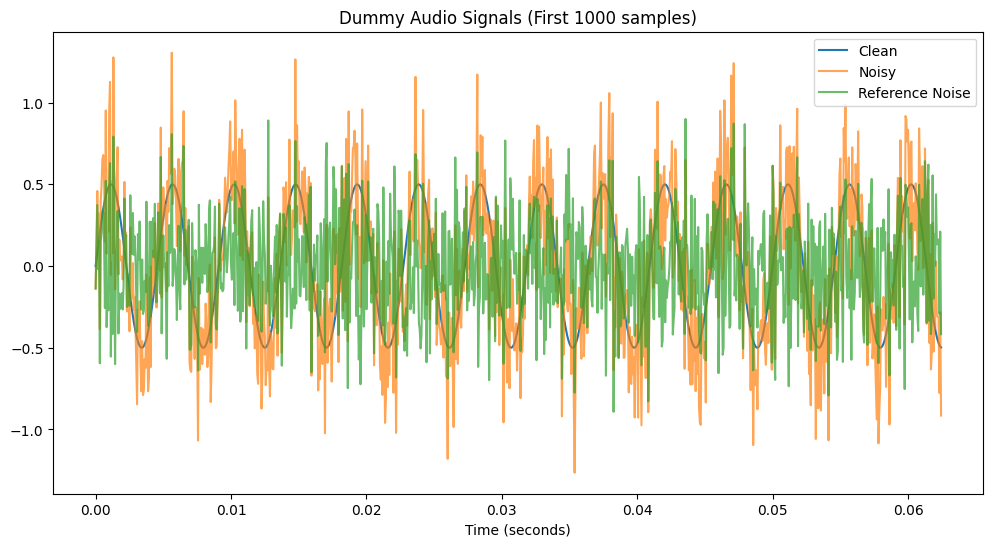

In [5]:
plt.figure(figsize=(12,6))
plt.plot(t[:1000], clean[:1000], label='Clean')
plt.plot(t[:1000], noisy[:1000], label='Noisy', alpha=0.7)
plt.plot(t[:1000], reference[:1000], label='Reference Noise', alpha=0.7)
plt.title('Dummy Audio Signals (First 1000 samples)')
plt.xlabel('Time (seconds)')
plt.legend()
plt.show()



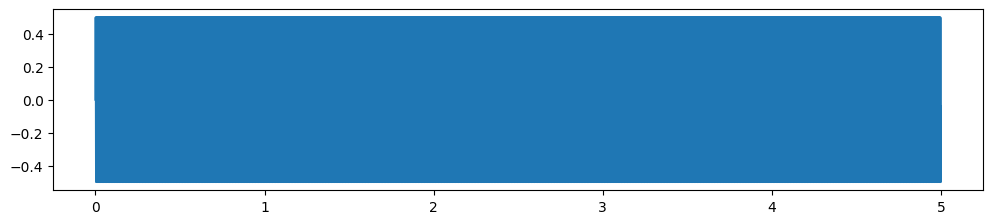

In [6]:
mu = 0.01
order = 32

w = np.zeros(order)
e = np.zeros(len(noisy))

for n in range(order, len(noisy)):
    x = reference[n-order:n][::-1]
    d = noisy[n]
    y = np.dot(w, x)
    e[n] = d - y
    w += 2 * mu * e[n] * x

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(t, clean)


In [7]:
def mse(x, y):
    min_len = min(len(x), len(y))
    return np.mean((x[:min_len] - y[:min_len])**2)

def snr(clean, noisy):
    min_len = min(len(clean), len(noisy))
    signal_power = np.mean(clean[:min_len]**2)
    noise_power = np.mean((clean[:min_len] - noisy[:min_len])**2)
    return 10 * np.log10(signal_power / noise_power)

print(f"MSE (Noisy vs Clean): {mse(noisy, clean):.6f}")
print(f"MSE (Denoised vs Clean): {mse(e, clean):.6f}")
print(f"SNR (Noisy vs Clean): {snr(clean, noisy):.2f} dB")
print(f"SNR (Denoised vs Clean): {snr(clean, e):.2f} dB")


MSE (Noisy vs Clean): 0.090353
MSE (Denoised vs Clean): 0.096494
SNR (Noisy vs Clean): 1.41 dB
SNR (Denoised vs Clean): 1.12 dB


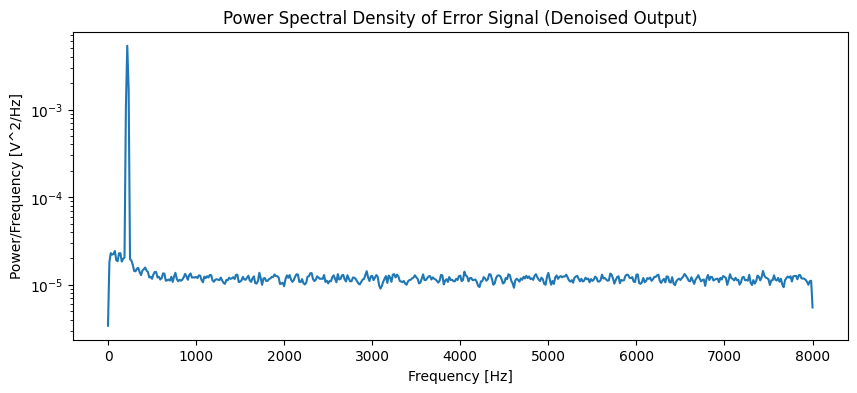

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

from scipy.signal import welch

f, Pxx = welch(e, fs, nperseg=1024)
plt.figure(figsize=(10,4))
plt.semilogy(f, Pxx)
plt.title('Power Spectral Density of Error Signal (Denoised Output)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V^2/Hz]')
plt.show()


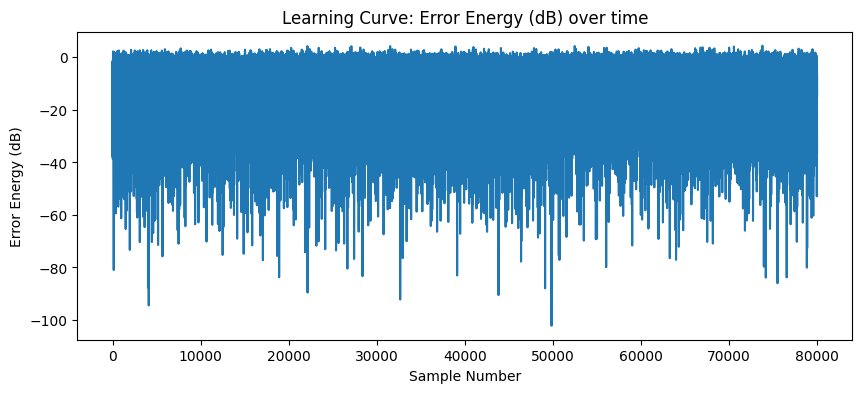

In [9]:
error_energy = (e**2)
plt.figure(figsize=(10,4))
plt.plot(10 * np.log10(error_energy[order:]))
plt.title('Learning Curve: Error Energy (dB) over time')
plt.xlabel('Sample Number')
plt.ylabel('Error Energy (dB)')
plt.show()


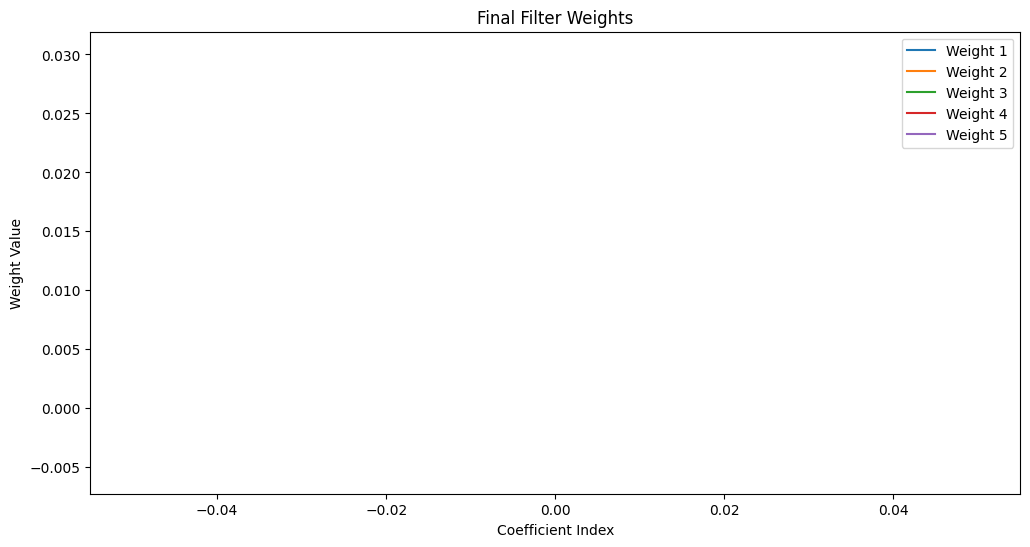

In [10]:
plt.figure(figsize=(12,6))
for i in range(min(5, len(w))):
    plt.plot(w[i], label=f'Weight {i+1}')
plt.title('Final Filter Weights')
plt.xlabel('Coefficient Index')
plt.ylabel('Weight Value')
plt.legend()
plt.show()


In [11]:
mu = 0.5
order = 32

w_nlms = np.zeros(order)
e_nlms = np.zeros(len(noisy))
epsilon = 1e-6

for n in range(order, len(noisy)):
    x = reference[n-order:n][::-1]
    d = noisy[n]
    y = np.dot(w_nlms, x)
    e_nlms[n] = d - y
    norm_x = np.dot(x, x) + epsilon
    w_nlms += (mu / norm_x) * e_nlms[n] * x



 Denoised Audio (NLMS Output)


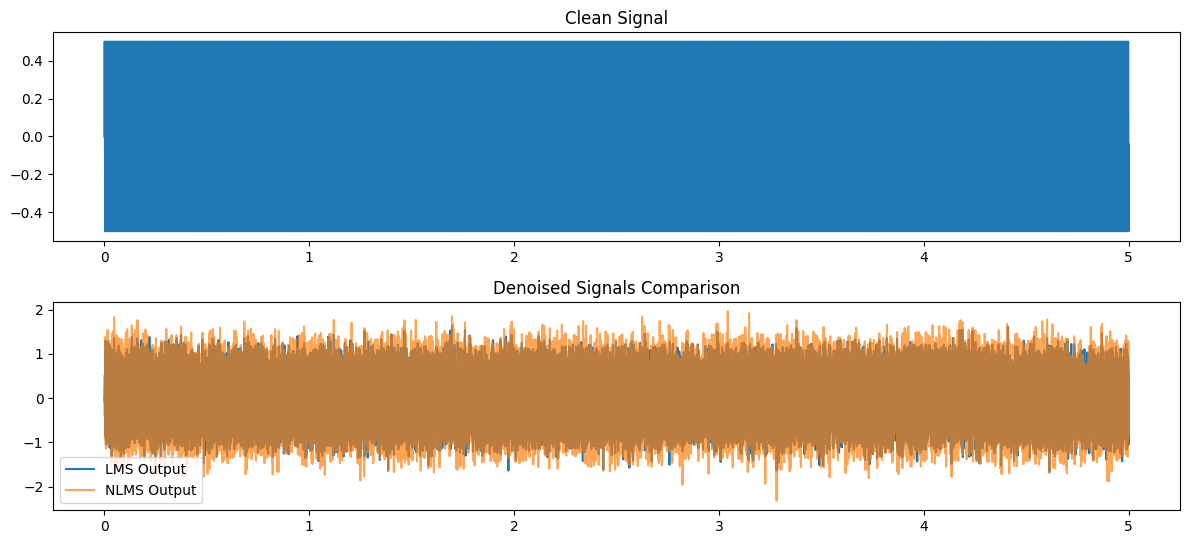

In [12]:
print("\n Denoised Audio (NLMS Output)")
display(Audio(e_nlms, rate=fs))

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(t, clean)
plt.title("Clean Signal")
plt.subplot(3,1,2)
plt.plot(t, e, label='LMS Output')
plt.plot(t, e_nlms, label='NLMS Output', alpha=0.7)
plt.title("Denoised Signals Comparison")
plt.legend()
plt.tight_layout()
plt.show()
